In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCTATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCATACAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAAGCGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGA...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGGTCGCTGAGCGCCATTTTT...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGACACCGCAATTCCCA...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGCTCTTCG...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 52069.20it/s]


[54, 162, 235, 326, 446, 496, 591, 715, 790, 914, 977, 1089, 1180, 1240, 1326, 1421, 1501, 1542, 1610, 1678, 1768, 1823, 1907, 1963, 2065, 2087, 2201, 2249, 2324, 2372, 2424, 2553, 2602, 2656, 2713, 2759, 2830, 2911, 2925, 2959, 3087, 3076, 3148, 3190, 3296, 3300, 3399, 3423, 3480, 3545, 3644, 3666, 3671, 3759, 3813, 3886, 3910, 3937, 3999, 4069, 4166, 4194, 4198, 4307, 4344, 4389, 4399, 4450, 4541, 4547, 4660, 4617, 4645, 4710, 4783, 4821, 4848, 4891, 5001, 5013, 5065, 5094, 5238, 5242, 5335, 5383, 5368, 5482, 5517, 5561, 5588, 5702, 5734, 5767, 5857, 5928, 5924, 6041, 6182, 6199, 6193, 6243, 6367, 6412, 6402, 6475, 6547, 6627, 6654, 6629]


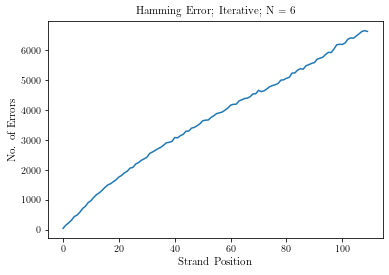

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:10<00:00, 936.98it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> GT 6
CT ->  6
G -> CA 6
CA ->  6
 -> TT 7
 -> AG 7
 -> GC 8
 -> TA 8
 -> GA 9
 -> TC 10
 -> AA 11
 -> CT 11
 -> TG 12
 -> AC 13
 -> CG 17
 -> AT 19
 -> CA 23
A -> T 121
A -> G 122
G -> T 135
C -> T 141
T -> C 155
A -> C 164
C -> G 170
T -> A 179
G -> C 187
G -> A 197
T -> G 199
C -> A 200
C ->  786
G ->  792
A ->  817
T ->  840
 -> T 2641
 -> G 2872
 -> C 2954
 -> A 3109


C ->  @ 2 6
A ->  @ 1 6
A ->  @ 90 6
A ->  @ 89 6
A ->  @ 24 6
C ->  @ 18 6
C ->  @ 100 6
C ->  @ 106 6
A ->  @ 35 6
A ->  @ 55 6
A ->  @ 67 6
C ->  @ 12 6
A ->  @ 68 6
G ->  @ 77 6
A ->  @ 54 6
C ->  @ 38 6
G ->  @ 82 6
A ->  @ 13 6
G ->  @ 97 6
G ->  @ 93 6
A ->  @ 15 6
A ->  @ 19 6
G -> A @ 12 6
C ->  @ 32 6
A ->  @ 103 6
A ->  @ 96 6
A ->  @ 101 6
A ->  @ 10 6
A ->  @ 21 6
A ->  @ 22 6
A ->  @ 23 6
A ->  @ 20 6
A ->  @ 3 6
G ->  @ 57 6
G ->  @ 68 6
T ->  @ 40 6
T ->  @ 76 6
C ->  @ 42 6
C ->  @ 8 6
T ->  @ 45 6
T ->  @ 104 6
G ->  @ 37 6
G ->  @ 25 6
T ->  @ 64 6
T ->  @ 80 6
T ->  @ 4 6
C -> T @ 91 6
G ->  @ 21 6
T ->  @ 85 6
C ->  @ 53 6
C ->  @ 99 6
T ->  @ 50 6
T -> A @ 62 6
G ->  @ 106 6
T ->  @ 60 6
T ->  @ 97 6
T ->  @ 47 6
T ->  @ 101 6
T ->  @ 9 6
G ->  @ 53 6
C ->  @ 56 7
G ->  @ 1 7
T ->  @ 46 7
G ->  @ 108 7
C ->  @ 10 7
A ->  @ 29 7
G ->  @ 100 7
T ->  @ 44 7
C ->  @ 59 7
C ->  @ 62 7
A ->  @ 41 7
T ->  @ 35 7
A ->  @ 73 7
C ->  @ 98 7
C ->  @ 97 7
A ->  @ 62 7
A ->  @

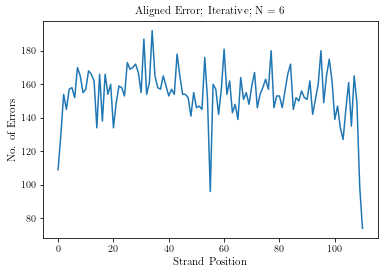

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 6', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov6-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[35, 23, 25, 34, 31, 30, 22, 34, 38, 31, 29, 33, 26, 31, 23, 22, 22, 27, 25, 31, 23, 24, 31, 26, 35, 39, 29, 36, 24, 43, 30, 38, 21, 20, 46, 35, 23, 29, 29, 22, 27, 27, 32, 37, 45, 32, 29, 20, 27, 23, 30, 26, 26, 29, 24, 19, 24, 25, 22, 27, 32, 29, 29, 24, 29, 23, 25, 31, 36, 19, 38, 21, 29, 29, 39, 31, 35, 27, 27, 29, 26, 30, 30, 36, 29, 23, 24, 15, 31, 32, 27, 35, 30, 27, 26, 34, 20, 25, 36, 30, 22, 26, 29, 23, 22, 26, 22, 27, 20, 13, 5]
[22, 27, 38, 20, 29, 22, 27, 23, 34, 26, 29, 28, 28, 30, 22, 35, 17, 32, 30, 30, 22, 30, 29, 19, 28, 25, 34, 35, 27, 16, 26, 30, 19, 33, 31, 32, 21, 26, 25, 33, 18, 26, 29, 32, 22, 24, 23, 27, 35, 29, 23, 27, 17, 35, 28, 24, 26, 23, 23, 33, 30, 28, 30, 24, 31, 20, 18, 20, 28, 31, 25, 31, 22, 28, 32, 27, 25, 28, 20, 24, 35, 32, 38, 18, 27, 22, 27, 30, 20, 23, 28, 30, 14, 26, 31, 39, 32, 30, 35, 20, 29, 24, 23, 24, 28, 29, 23, 26, 27, 17, 11]
[33, 24, 28, 19, 30, 30, 30, 41, 22, 24, 25, 31, 25, 24, 23, 31, 18, 36, 14, 26, 18, 29, 13, 33, 20, 33, 23, 22

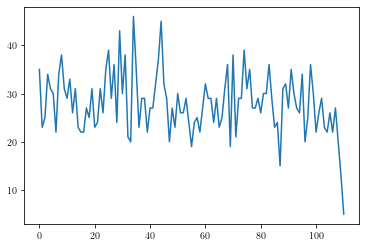

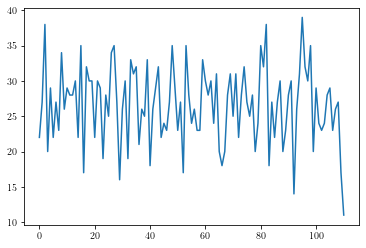

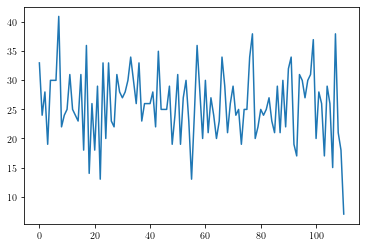

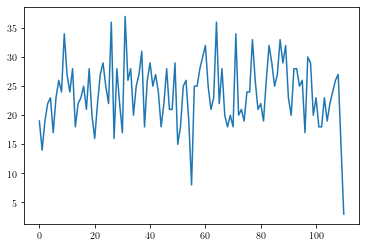

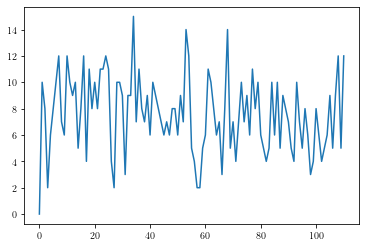

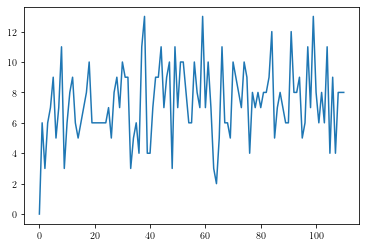

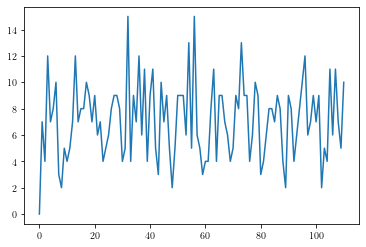

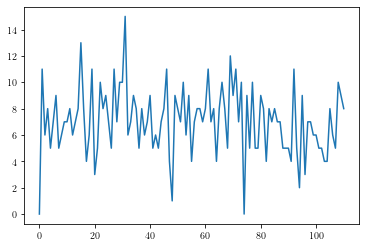

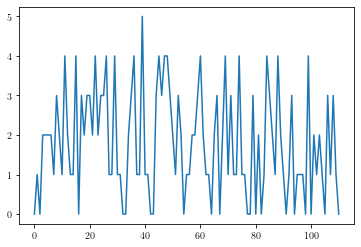

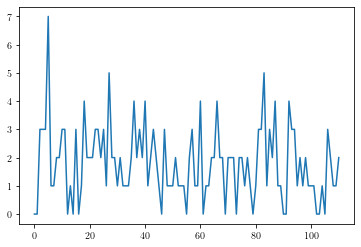

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)